In [80]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob
from collections import defaultdict
import numpy as np

## Core components

#### Parse JSON logs

In [249]:
def parse_champions(logs_file_iter):
    result = {}
    current_line = next(logs_file_iter, '{}')
    line_json = json.loads(current_line)
    while line_json.get('type', None) == 'ChampionSpawnedReport':
        name = line_json['value']['controller_name']
        coords = tuple(line_json['value']['coords'])
        champion_data = {
            'name': name,
            'start_coords': coords,
            'last_coords': coords,
            'failed_steps': [],  # every item is a dict {'episode', 'error_text', 'coords'}
            'actions': [],
            'episode_died': -1,
            'last_attack_type': None
        }
        result[name] = champion_data
        current_line = next(logs_file_iter, '{}')
        line_json = json.loads(current_line)
    return result, current_line if current_line != '{}' else None

In [250]:
def parse_game_course(current_line, logs_file_iter, game_report):
    if current_line is None:
        return None
    champions_info = game_report['bots']
    
    line_json = json.loads(current_line)
    episode_number = 0
    mist_started = False
    while line_json.get('type', None) not in ('GameStartReport', None):
        event_type = line_json['type']
        bot_name = line_json.get('value', {}).get('controller_name', None)
        bot_data = champions_info.get(bot_name, None)
        
        if event_type == 'EpisodeStartReport':
            game_report['episodes_number'] = episode_number
            episode_number = int(line_json['value']['episode_number'])
        elif line_json['severity'] == 'WARNING':
            error_text = line_json['value']['exception']
            coords = bot_data['last_coords']
            bot_data['failed_steps'].append({
                'episode': episode_number,
                'error_text': error_text,
                'coords': coords
            })
        elif event_type == 'ChampionPickedActionReport':
            action = line_json['value']['action_name']
            bot_data['actions'].append(action)
        elif event_type == 'ChampionEnteredTileReport':
            new_coords = tuple(line_json['value']['tile_coords'])
            bot_data['last_coords'] = new_coords
        elif event_type == 'ChampionDeathReport':
            bot_data['episode_died'] = episode_number
        elif event_type == 'ChampionDamagedByMistReport':
            bot_data['last_attack_type'] = 'mist'
        elif event_type == 'ChampionDamagedByWeaponCutReport':
            bot_data['last_attack_type'] = 'weapon'
        elif event_type == 'MistRadiusReducedReport' and not mist_started:
            mist_started = True
            game_report['mist_episode'] = episode_number
        
        current_line = next(logs_file_iter, '{}')
        line_json = json.loads(current_line)
    return current_line if current_line != '{}' else None

In [251]:
def parse_games_json_logs(logs_path):
    with open(logs_path) as logs_file:
        logs_file_iter = iter(logs_file)
        result = []
        current_line = next(logs_file_iter, None)
        while current_line is not None:
            game_json = json.loads(current_line)
            arena_json = json.loads(next(logs_file_iter, 'null'))
            menhir_json = json.loads(next(logs_file_iter, 'null'))
            champions, current_line = parse_champions(logs_file_iter)
            if not all((arena_json, menhir_json, champions)):
                print('Not all metadata provided')
                break
            game_report = {
                'game_number': int(game_json['value']['game_number']),
                'mist_episode': -1,
                'menhir_pos': tuple(menhir_json['value']['position']),
                'arena_name': arena_json['value']['arena_name'],
                'bots': champions,
                'episodes_number': 0
            }

            current_line = parse_game_course(current_line, logs_file_iter, game_report)
            result.append(game_report)
    return result

#### Parsed data analysis

In [188]:
def get_bot_survival_info(games, bot_name):
    survivals_info = {
        'data': [],
        'total_losses': 0,
        'losses_with_failures': 0
    }
    failures_info = []
    survivals = []
    for game in games:
        bot_died = game['bots'][bot_name]['episode_died']
        if bot_died > 0:
            survivals_info['total_losses'] += 1
        else:
            bot_died = game['episodes_number']
        game_number = game['game_number']
        survivals.append([game_number, bot_died])
        if game['bots'][bot_name]['failed_steps']:
            failures_info.append([game_number, bot_died])
            if game['bots'][bot_name]['episode_died'] > 0:
                survivals_info['losses_with_failures'] += 1
    survivals_info['data'] = np.array(survivals)
    return survivals_info, failures_info

In [183]:
def plot_bot_survival_dynamics(games, bot_name, figure, with_errors=True):
    survivals_info, failures_info = get_bot_survival_info(games, bot_name)
    survivals = survivals_info['data']
    plt.plot(survivals[:,0], survivals[:,1], figure=figure, label=bot_name, linewidth=0.7, color=COLORS[bot_name])
    if with_errors and failures_info:
        failures = np.array(failures_info)
        plt.scatter(failures[:,0], failures[:,1], marker='x', figure=figure, color=COLORS[bot_name], linewidth=2.5)

In [225]:
def split_lost_games_based_on_reason(games, bot_name):
    lost_games = []
    fault_games = []
    for game in games:
        bot = game['bots'][bot_name]
        if bot['episode_died'] < 1:
            continue
        
        if bot['failed_steps']:
            fault_games.extend([
                {'exception_text': step['error_text'], 'game_number': game['game_number']} for step in bot['failed_steps']
            ])
        else:
            lost_games.append({'reason': bot['last_attack_type'], 'coords': bot['last_coords'],
                               'arena_name': game['arena_name']})
    return lost_games, fault_games

In [306]:
def load_arena(arena_name):
    arena_path = f'../resources/arenas/{arena_name}.gupb'
    with open(arena_path) as arena_file:
        arena = arena_file.readlines()
        size = (len(arena[0]) - 1, len(arena))
    return arena, size

In [321]:
def draw_map(loaded_arena, arena_size):
    TERRAIN_TILES = {'=': 50, '.': 150, '#': 200}
    terrain_map = np.zeros(arena_size, dtype=np.int16)

    fig, ax = plt.subplots(figsize=(16, 12))
    plt.axis('off')

    for i in range(arena_size[0]):
        for j in range(arena_size[1]):
            terrain = loaded_arena[j][i]
            terrain_map[j,i] = TERRAIN_TILES.get(terrain, 150)
            ax.text(i, j, terrain, ha='center', va='center', color='w')

    ax.imshow(terrain_map, cmap='seismic')

In [323]:
def draw_killmap(death_counts, arena_size):
    arena_killmap = np.zeros(arena_size, dtype=np.int16)
    for coord in death_counts.index:
        arena_killmap[coord[1], coord[0]] = death_counts['death_count'][coord]
    fig, ax = plt.subplots(figsize=(16, 12))
    plt.axis('off')
    ax.imshow(arena_killmap, cmap='coolwarm')

    for i in range(arena_size[0]):
        for j in range(arena_size[1]):
            ax.text(i, j, arena_killmap[i,j], ha='center', va='center', color='w')

## Before running the parser
> The parser `.ipynb` is put under `GUPB/log-parse` and all paths to logs are relative to this location. Be sure that the files are downloaded and placed there, because they are not under Git

**The schema:**
```json
[
    {
        "game_number": int,
        "mist_episode": int (-1 if a game ended quicker than the mist started),
        "menhir_pos": [int, int],
        "arena_name": string,
        "episodes_number": int,
        "bots": {
            "bot_name_1": {
                "name": string,
                "start_coords": [int, int],
                "last_coords": [int, int],
                "failed_steps": [
                    {
                        "episode": int,
                        "error_text": string,
                        "coords": [int, int]
                    },
                    ...
                ],
                "actions": [string, string, ...],
                "episode_died": int (-1 if a last bot standing),
                "last_attack_type": string (either 'mist' or 'weapon')
            },
            "bot_name_2": ...,
            ...
        }
    },
    ...
]
```

## Example log

In [252]:
example_path = 'example_log.json'
example_parsed_data = parse_games_json_logs(example_path)

In [66]:
[f'{key}: {example_parsed_data[0][key]}' for key in example_parsed_data[0] if key != 'bots']

['game_number: 1',
 'mist_episode: 25',
 'menhir_pos: [9, 9]',
 'arena_name: isolated_shrine',
 'episodes_number: 477']

## 11:15 games

In [9]:
DIR_PATH_11_15 = '11_15__2021_10_24'
log_files = glob.glob(f'{DIR_PATH_11_15}/*.json')

In [21]:
json_log_path = log_files[0]

In [253]:
games = parse_games_json_logs(json_log_path)

In [254]:
games_df = pd.DataFrame(games)
games_df.head()

,game_number,mist_episode,menhir_pos,arena_name,bots,episodes_number
0,1,20,"(9, 9)",isolated_shrine,{'EkonometronControllerJohnathan': {'name': 'E...,182
1,2,20,"(9, 9)",isolated_shrine,{'EkonometronControllerJohnathan': {'name': 'E...,179
2,3,20,"(9, 9)",isolated_shrine,"{'BB8': {'name': 'BB8', 'start_coords': (7, 14...",103
3,4,15,"(9, 9)",isolated_shrine,{'EvaderController--MarwinWise': {'name': 'Eva...,119
4,5,20,"(9, 9)",isolated_shrine,"{'Felix': {'name': 'Felix', 'start_coords': (8...",194


In [255]:
bins_number = 20
bin_size = len(games) // bins_number

In [141]:
fonts_dict = {
    'fontsize': 12
}

In [199]:
bot_name = 'EvaderController--MarwinWise'

### Survival dynamics

In [172]:
COLORS = {
    'EvaderController--MarwinWise': 'limegreen',
    'FunnyController': 'purple',
    'BerserkBotRagnar': 'darkred',
    'R2D2': 'navy',
    'BB8': 'orange',
    'Bandyta1.0': 'teal',
    'EkonometronControllerJohnathan': 'brown',
    'Felix': 'mediumvioletred',
    'WIETnamczykAdam': 'black'
}

In [157]:
bin_1 = games[:bin_size]
games_length = np.array([[game['game_number'], game['episodes_number']] for game in bin_1])
total_games_length = np.array([[game['game_number'], game['episodes_number']] for game in games])

> TODO: should be also done grouping games by arena

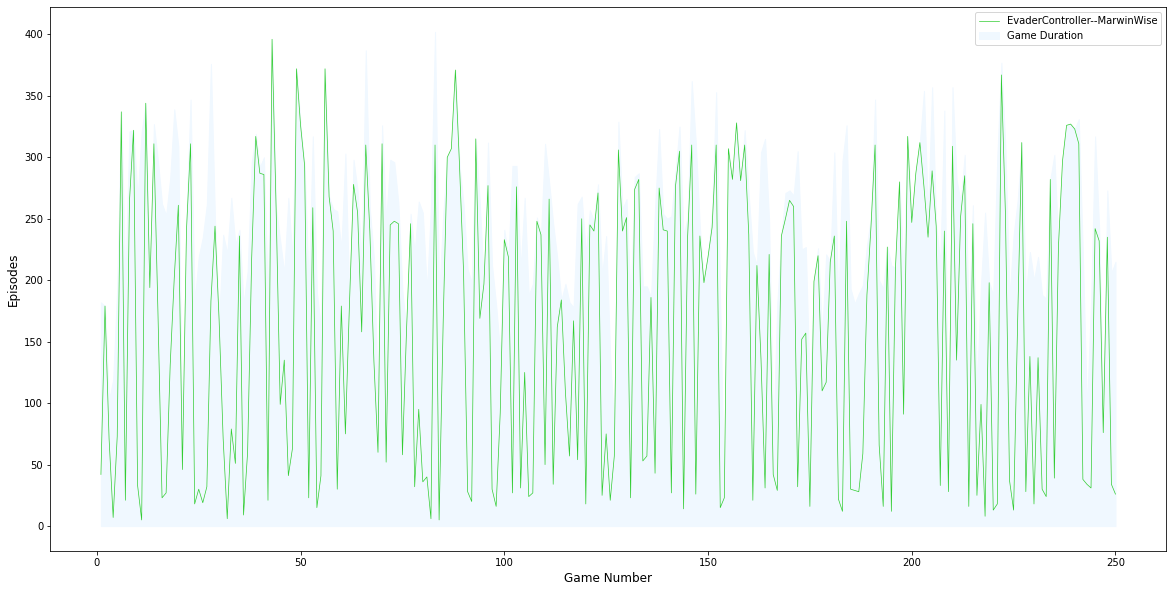

In [201]:
fig = plt.figure(figsize=(20, 10))
top_n = 250
# plt.plot(total_games_length[:top_n,0], total_games_length[:top_n,1], figure=fig)
plt.fill_between(total_games_length[:top_n,0], total_games_length[:top_n,1],
                 figure=fig, color='aliceblue', label='Game Duration')
plot_bot_survival_dynamics(games[:top_n], bot_name, fig, with_errors=False)
plt.legend()
plt.xlabel('Game Number', fontdict=fonts_dict)
plt.ylabel('Episodes', fontdict=fonts_dict)
pass

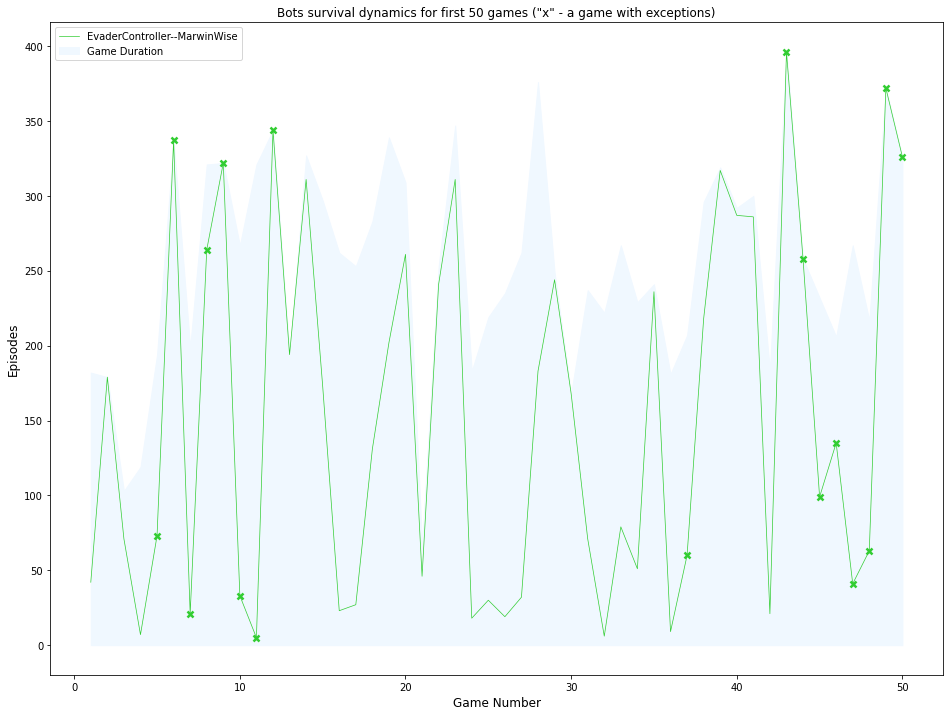

In [202]:
fig = plt.figure(figsize=(16, 12))
# plt.plot(games_length[:,0], games_length[:,1], figure=fig, label='Game Duration')
plt.fill_between(games_length[:,0], games_length[:,1], color='aliceblue', label='Game Duration')
plot_bot_survival_dynamics(bin_1, bot_name, fig)
plt.legend()
plt.xlabel('Game Number', fontdict=fonts_dict)
plt.ylabel('Episodes', fontdict=fonts_dict)
plt.title('Bots survival dynamics for first 50 games ("x" - a game with exceptions)')
pass

#### Losses with and without errors ratio

In [189]:
bots_survival_info = []
for bot_name in bin_1[0]['bots']:
    survival_info, failures_info = get_bot_survival_info(games, bot_name)
    total_losses = survival_info['total_losses']
    errors_losses = survival_info['losses_with_failures']
    bots_survival_info.append({
        'bot': bot_name,
        'no_errors_losses': (total_losses - errors_losses),
        'errors_losses': errors_losses,
        'games_with_errors': len(failures_info)
    })

In [190]:
losses_ratio_df = pd.DataFrame(bots_survival_info)
losses_ratio_df

,bot,no_errors_losses,errors_losses,games_with_errors
0,EkonometronControllerJohnathan,744,0,0
1,BB8,473,524,526
2,EvaderController--MarwinWise,560,437,437
3,Felix,262,0,0


<AxesSubplot:ylabel='bot'>

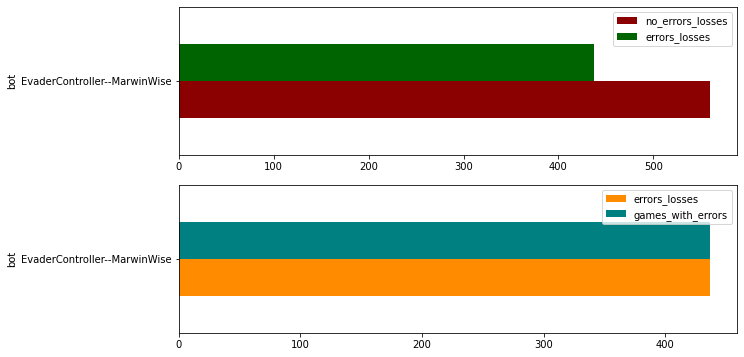

In [210]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
bot_losses_df = losses_ratio_df[losses_ratio_df.bot == bot_name]
losses_columns = ['bot', 'no_errors_losses', 'errors_losses']
bot_losses_df[losses_columns].plot.barh(ax=ax[0], x='bot', color={'no_errors_losses': 'darkred', 'errors_losses': 'darkgreen'})
errors_columns = ['bot', 'errors_losses', 'games_with_errors']
bot_losses_df[errors_columns].plot.barh(ax=ax[1], x='bot', color={'errors_losses': 'darkorange', 'games_with_errors': 'teal'})

### Death Reasons

In [256]:
lost_games, fault_games = split_lost_games_based_on_reason(games, bot_name)

In [257]:
fault_df = pd.DataFrame(fault_games)
fault_df.groupby(['exception_text'])\
                .agg(count=('game_number', 'count'))\
                .sort_values(['count'], ascending=False)\
                .head(25)

,count
exception_text,
"KeyError(Coords(x=17, y=13))",20062
"KeyError(Coords(x=15, y=5))",10003
"KeyError(Coords(x=8, y=7))",7932
"KeyError(Coords(x=13, y=7))",5393
"KeyError(Coords(x=10, y=10))",4764
"KeyError(Coords(x=7, y=6))",4720
"KeyError(Coords(x=8, y=8))",4047
"KeyError(Coords(x=9, y=8))",3094
"KeyError(Coords(x=7, y=7))",2356


In [258]:
lost_games_df = pd.DataFrame(lost_games)
lost_games_df.groupby(['arena_name', 'reason']).agg(count=('coords', 'count'))

count
arena_name      reason       
isolated_shrine mist        1
                weapon    559

### The Map

In [259]:
map_grouped = lost_games_df.groupby(['arena_name'])
map_to_analyse, map_data = next(iter(map_grouped))
map_to_analyse

'isolated_shrine'

In [308]:
loaded_arena, arena_size = load_arena(map_to_analyse)
print(''.join(loaded_arena))

=M...............M=
=.=..====B==.S===.=
=.==A...=#=..===..=
=.=====.....===A..=
=.S==##.....##=.=.=
=...=#..###..#=.=.=
=.=......#......=.=
=.==..#.....#..==.=
=.B#..##...##..#B.=
=.==..#.....#..==.=
=.=......#......=.=
=.=.=#..###..#=...=
=.=.=##.....##==S.=
=..A===.....=====.=
=..===..=#=...A==.=
=.===S.==B====..=.=
=M...............M=


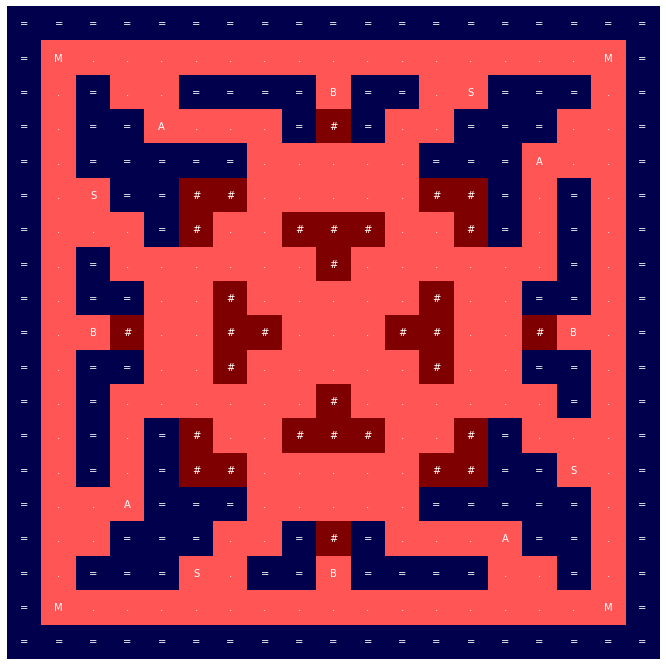

In [322]:
draw_map(loaded_arena=loaded_arena, arena_size=arena_size)

### Heatmap of Deaths

In [265]:
death_counts = map_data.groupby(['coords']).agg(death_count=('arena_name', 'count'))

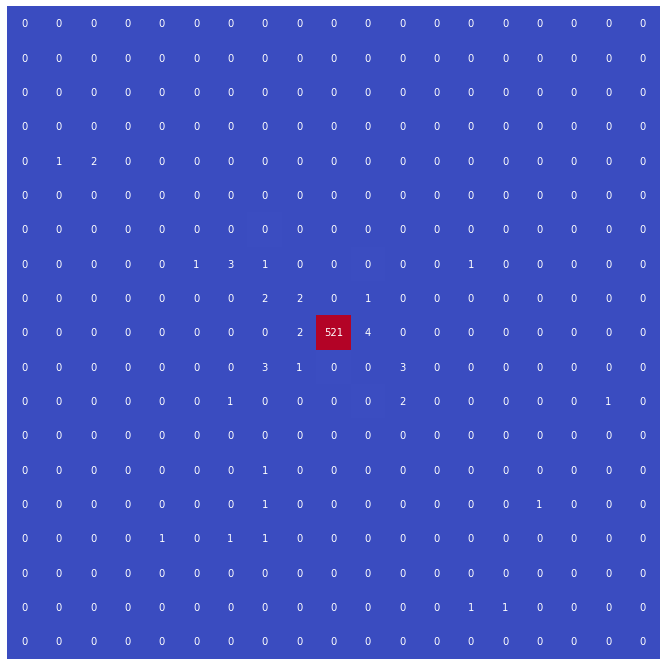

In [324]:
draw_killmap(death_counts, arena_size)